In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import torch
from omegaconf import OmegaConf

import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import wandb

In [3]:
DATA_PATH = '/braid/havivd/hbca_immune/hbca_immune.h5ad'

In [4]:
DATA_PATH = '/braid/havivd/scgen/kang.h5ad'
MODEL_PATH = '/braid/havivd/scgen/kang_model_params.pth'

In [5]:
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = False

Load data

In [6]:
adata = ad.read_h5ad(DATA_PATH)

Setup model

In [7]:
concept_key = 'concepts'
n_concepts = adata.obsm[concept_key].shape[1]

config_dict = dict(has_cbm = True, 
                       lr = 5e-4,
                       hidden_dim = 256,
                       beta = 1e-5,
                       input_dim = adata.shape[1],
                       latent_dim = 128,
                       n_concepts = n_concepts,
                       min_bottleneck_size = 128, # important
                       independent_training = True,
                       concepts_hp = 0.005,
                       orthogonality_hp = 0.2, # important
                       use_soft_concepts = False,
                      )
    
model_type = clab.models.scCBGM


config = OmegaConf.create(config_dict)

model = model_type(config)

Setup analysis

In [8]:
labels = adata.obs['cell_stim'] # labels to use
hold_out_label = 'CD4 T cells_stim' # label of cells to be held out
mod_label = 'CD4 T cells_ctrl' # label of cells to be modified

Set random seeds

In [9]:
np.random.seed(69)
torch.manual_seed(69)

Split into train, intervention, and reference (test) sets

In [10]:
is_test = np.isin(labels.values, [hold_out_label])
is_inter = np.isin(labels.values, mod_label)
inter_mask = np.random.binomial(1,
                                p=0.2, # important, keep quite low to have enough training data
                                size = len(is_inter)).astype(bool)
is_inter = is_inter * inter_mask
is_train = ~is_test & ~is_inter

Normalize data

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

Split data. We will train on `adata_train`, intervene on `adata_inter` and compare with `adata_test`.

In [12]:
adata_train = adata[is_train].copy()
adata_test  = adata[is_test].copy()
adata_inter=  adata[is_inter].copy()

Setup data module

In [13]:
data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        add_concepts=True,
        concept_key='concepts',
        batch_size=512,
        normalize=False,
    )

initialize logger

In [14]:
# if not USE_SAVED_MODEL:
#     wandb_logger = WandbLogger(
#             project='zero_shot_demo_002',
#             log_model=False,
#         )

Configure trainer

In [15]:
if not USE_SAVED_MODEL:
    trainer = pl.Trainer(
            max_epochs=200, log_every_n_steps = 10,
        )


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /homefs/home/havivd/miniforge3/envs/conceptlab/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the M

Fit model

In [16]:
if not USE_SAVED_MODEL:
    trainer.fit(model, data_module,)
    if OVERWRITE_SAVED_MODEL: torch.save(model.state_dict(), MODEL_PATH )
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                | Params | Mode 
-------------------------------------------------------------------
0 | _encoder           | DefaultEncoderBlock | 2.4 M  | train
1 | cb_concepts_layers | Sequential          | 1.2 K  | train
2 | cb_unk_layers      | Sequential          | 16.5 K | train
3 | _decoder           | SkipDecoderBlock    | 2.5 M  | train
4 | dropout            | Dropout             | 0      | train
-------------------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.736

Epoch 199: 100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 29.40it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.81it/s, v_num=8]


Move model to CPU and put in eval mode

In [17]:
model.to("cpu")
model.eval()

scCBGM(
  (_encoder): DefaultEncoderBlock(
    (encoder_layers): Sequential(
      (0): Linear(in_features=9224, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (fc_var): Linear(in_features=256, out_features=128, bias=True)
  )
  (cb_concepts_layers): Sequential(
    (0): Linear(in_features=128, out_features=9, bias=True)
    (1): Sigmoid()
  )
  (cb_unk_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (_decoder): SkipDecoderBlock(
    (decoder_layers): Sequential(
      (0): SkipLayer(
        (fc): Linear(in_features=137, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): SkipLayer(
        (fc): Linear(in_features=265, out_features=9224, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

Get data to intervene on (the model has never seen these cells)

In [18]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_intervene_on =  adata_inter.obsm['concepts'].values.astype(np.float32).copy()

Intervene on the stim concept (last) setting it to zero for all the cells in the intervention data

In [19]:
# create intervention mask
mask = np.zeros_like(c_intervene_on)
inter_concepts = c_intervene_on.copy()
# define which concept should be intervened on and to what value
inter_concepts[:,-1] = 1
mask[:,-1] = 1

# to tensor
mask = torch.tensor(mask.astype(np.float32))
inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

# perform intervention
inter_preds = model.intervene(torch.tensor(x_intervene_on), mask = mask, concepts= inter_concepts)

# get predicted gene expression
x_inter_preds = inter_preds['x_pred'].detach().cpu().numpy()

Create anndata object of predicted data

In [20]:
adata_pred = ad.AnnData(x_inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )

/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [21]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [22]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [23]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [24]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [25]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [26]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Order categories for plotting

In [27]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [30]:
ct_cmap = {'B cells': "#e91111",
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

Plot Results (Figure 1)

/tmp/ipykernel_3440124/4073372265.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing


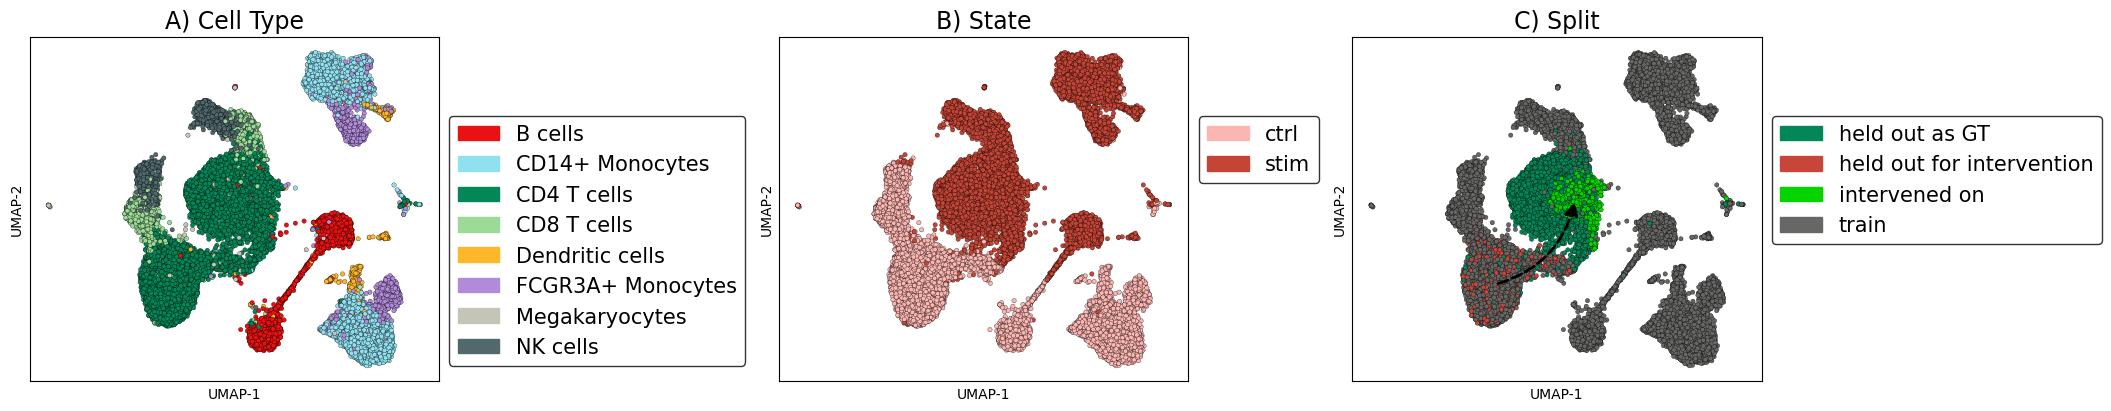

In [31]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string


fig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout = True)
#for k,color in enumerate([ 'cell', 'stim', 'ident']):
for k,(color,cmap) in enumerate(zip([ 'cell', 'stim', 'ident'],[ct_cmap, stim_cmap, ident_cmap])):

    emb_x,emb_y = sub_adata.obsm['X_umap'][:,0], sub_adata.obsm['X_umap'][:,1]
    labels = sub_adata.obs[color].values
    colors = np.array([cmap[lab] for lab in labels])

    rix = np.arange(colors.shape[0])
    np.random.shuffle(rix)


    
    ax[k].scatter(emb_x[rix],
                  emb_y[rix],
                  c = colors[rix],
                  s=10,
                  edgecolor = 'black',
                  linewidth = 0.2,
                  )

    # Add legend based on ct_cmap
    handles = [mpatches.Patch(color=cmap[label], label=label) 
               for label in np.unique(labels)]
    
    legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8))
    legend.get_frame().set_edgecolor("black")
    ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        center_source = (emb_x[source_ix].mean(),emb_y[source_ix].mean())
        center_target = (emb_x[target_ix].mean(),emb_y[target_ix].mean())

        arrow = patches.FancyArrowPatch(
                                        center_source, center_target,  # Start and end points
                                        connectionstyle="arc3,rad=0.3",  # Controls curvature (rad=0.3 defines the radius)
                                        arrowstyle="-|>",  # Arrow head style
                                        linewidth=2,
                                        linestyle = 'dashed',
                                        color="black",
                                         mutation_scale=20,
        )

        ax[k].add_patch(arrow)

        
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing
#fig.tight_layout()

# Flow Matching

In [33]:
import sklearn.decomposition

In [34]:
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=512).fit(adata.X)
adata.obsm['X_pca'] = adata.uns['pc_transform'].transform(adata.X)

# sc.pp.pca(adata, n_comps = 512)
adata_train.obsm['X_pca'] = adata[adata_train.obs.index].obsm['X_pca']
adata_test.obsm['X_pca'] = adata[adata_test.obs.index].obsm['X_pca']

In [36]:
fm_model = clab.models.cb_fm.CB_FM(x_dim=adata_train.obsm['X_pca'].shape[-1], c_dim=adata_train.obsm['concepts'].to_numpy().shape[-1], emb_dim=128, n_layers=4)
#fm_model = clab.models.cb_fm.CB_FM(x_dim=adata_train.X.shape[-1], c_dim=adata_train.obsm['concepts_soft'].to_numpy().shape[-1], emb_dim=128, n_layers=4)

In [39]:
fm_model.train(
    data=torch.from_numpy(adata_train.obsm['X_pca']).float(),
    concepts=torch.from_numpy(adata_train.obsm['concepts'].to_numpy()).float(),
    num_epochs=1000,
    batch_size=128,
    lr=3e-4,
    p_drop=0.1,
    ot = True
)

Training FM for 1000 epochs, with a batch size of 128 and ot True, using the adam optimizer with lr = 0.0003 and 0.998 decay


Epoch 1000/1000 | Loss: 1.0554, OT Improvement 0.9142: 100%|█| 1000/1000 [20:07<00:00,  


## Intervention

In [40]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_intervene_on =  adata_inter.obsm['concepts'].values.astype(np.float32).copy()

In [47]:
inter_preds.shape

torch.Size([1013, 512])

In [49]:
# create intervention mask
mask = np.zeros_like(c_intervene_on)
inter_concepts = c_intervene_on.copy()
# define which concept should be intervened on and to what value
inter_concepts[:,-1] = 1
mask[:,-1] = 1

# to tensor
mask = torch.tensor(mask.astype(np.float32))
inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

# perform intervention
inter_preds =  fm_model.sample(concepts = inter_concepts,
                               num_samples = inter_concepts.shape[0],
                               timesteps = 1000,
                               w = 2)
inter_preds = inter_preds.detach().cpu().numpy()
# get predicted gene expression
x_inter_preds = adata.uns['pc_transform'].inverse_transform(inter_preds)
adata_pred = ad.AnnData(x_inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )

Generating 1013 samples with CFG of gamma = 2


Sampling:   0%|                                                | 0/1000 [00:00<?, ?it/s]

Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 637.62it/s]
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [50]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [51]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [52]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [53]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [54]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [55]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Order categories for plotting

In [56]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [57]:
ct_cmap = {'B cells': "#e91111",
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

Plot Results (Figure 1)

/tmp/ipykernel_3440124/4073372265.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing


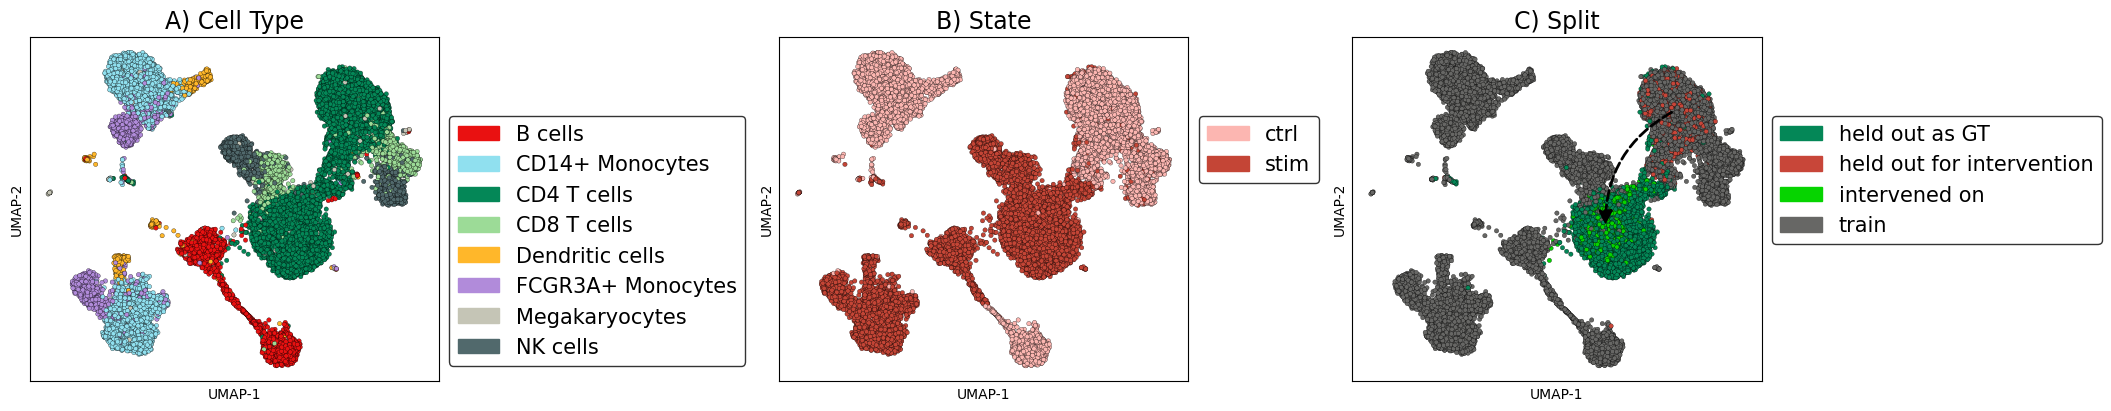

In [58]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string


fig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout = True)
#for k,color in enumerate([ 'cell', 'stim', 'ident']):
for k,(color,cmap) in enumerate(zip([ 'cell', 'stim', 'ident'],[ct_cmap, stim_cmap, ident_cmap])):

    emb_x,emb_y = sub_adata.obsm['X_umap'][:,0], sub_adata.obsm['X_umap'][:,1]
    labels = sub_adata.obs[color].values
    colors = np.array([cmap[lab] for lab in labels])

    rix = np.arange(colors.shape[0])
    np.random.shuffle(rix)


    
    ax[k].scatter(emb_x[rix],
                  emb_y[rix],
                  c = colors[rix],
                  s=10,
                  edgecolor = 'black',
                  linewidth = 0.2,
                  )

    # Add legend based on ct_cmap
    handles = [mpatches.Patch(color=cmap[label], label=label) 
               for label in np.unique(labels)]
    
    legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8))
    legend.get_frame().set_edgecolor("black")
    ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        center_source = (emb_x[source_ix].mean(),emb_y[source_ix].mean())
        center_target = (emb_x[target_ix].mean(),emb_y[target_ix].mean())

        arrow = patches.FancyArrowPatch(
                                        center_source, center_target,  # Start and end points
                                        connectionstyle="arc3,rad=0.3",  # Controls curvature (rad=0.3 defines the radius)
                                        arrowstyle="-|>",  # Arrow head style
                                        linewidth=2,
                                        linestyle = 'dashed',
                                        color="black",
                                         mutation_scale=20,
        )

        ax[k].add_patch(arrow)

        
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing
#fig.tight_layout()